# Тестирование гипотез

Тестирование гипотез - это фундаментальная концепция, важность которой для современного мира сложно переоценить. Ее суть заключается в том, чтобы проверить, какова вероятность получить данные, наблюдаемые экспериментально, в рамках модельного распределения. Например, если мы исследуем вес населения, у нас есть все основания предполагать, что он распеределен нормально, соответственно и сравнивать данные своего эксперимента мы будем с нормальным распредлением.

Тестирование всегда начинается с определения нулевой гипотезы. Ее точная формулировка зависит от исследуемых нами данных, но суть всегда одна - сохранить статус кво. Так, если мы сравниваем между собой две группы (как в A/B тестах), нулевая гипотеза будет утверждать, что между ними нет никакой разницы.

Следующий шаг - определение альтернативной гипотезы. Ее формулировка отличается в зависимости от проводимого нами теста, но суть всегда одна - служить антитезой нулевой гипотезе. Соответственно, при сравнении двух групп, альтернативная гипотеза будет утверждать что разница между этими группами все-таки есть .

Далее мы должны установить уровень значимости, чаще всего обозначаемый как **α** или **FPR** (false positive rate). По сути, это выбранная нами вероятность того, что мы отвергнем нулевую гипотезу, даже если она верна. На практике часто используется уровень в 5%. Само процесс тестирования гипотезы и заключается в том, чтобы получить вероятность получения экспериментальных данных в рамках модельного распределения и сравнить с FPR. Если вероятность ниже FPR, то мы можем отвергнуть нулевую гипотезу.

**Важно!** У тестирования гипотезы может быть только два результата: мы можем отвергнуть нулевую гипотезу или не иметь достаточных оснований для того, чтобы ее отвергнуть. Отсутствие оснований не означает, что нулевая гипотеза верна, это значит лишь, что у нас нет свидедельств, позволяющих ее отвергнуть.

# Ошибки первого и второго типа (Type 1 and Type 2 errors)
Ошибка первого типа - это возможность отвергнуть нулевую гипотезу, которую на самом деле отвергать не стоило. Ее вероятность - это FPR, которую мы задаем сами до расчета p-value.
Ошибка второго типа - это возможность **не отвергнуть** нулевую гипотезу, которую, на самом деле, нужно было отвергнуть (False negative rate).
Нарисуем график, чтобы лучше проиллюстрировать эти концепции и показать их взаимосвязь.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import statsmodels.stats as sms
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import tt_solve_power
from statsmodels.stats.anova import AnovaRM
import ipywidgets as widgets


Text(-0.1, 0.02, 'Type 2 Error')

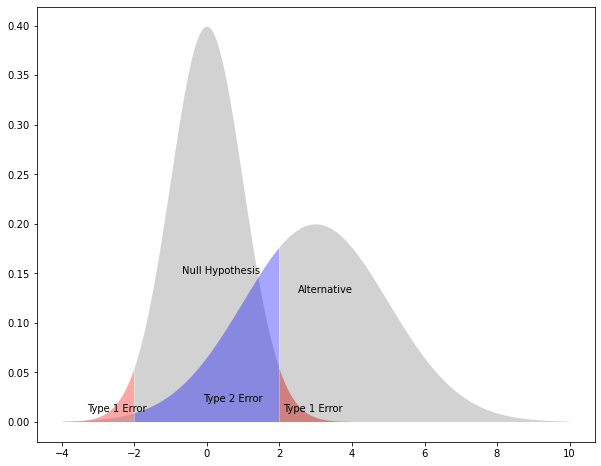

In [2]:
s=2
plt.figure(figsize=(10,8))
x=np.arange(-4, -s, 0.01)
x1=np.arange(-s, s, 0.01)
x2=np.arange(s, 4, 0.01)

plt.fill_between(
    x=x,
    y1=stats.norm.pdf(x),
    facecolor='red',
    alpha=0.35
)

plt.fill_between(
    x=x1,
    y1=stats.norm.pdf(x1),
    facecolor='gray',
    alpha=0.35
)

plt.fill_between(
    x=x2,
    y1=stats.norm.pdf(x2),
    facecolor='red',
    alpha=0.5
)

plt.fill_between(
    x=x,
    y1=stats.norm.pdf(x, loc=3, scale=2),
    facecolor='grey',
    alpha=0.35
)

plt.fill_between(
    x=x1,
    y1=stats.norm.pdf(x1, loc=3, scale=2),
    facecolor='blue',
    alpha=0.35
)

plt.fill_between(
    x=np.arange(s,10,0.01), 
    y1= stats.norm.pdf(np.arange(s,10,0.01),loc=3, scale=2),
    facecolor='grey',
    alpha=0.35
)
plt.text(x=-0.7, y=0.15, s= "Null Hypothesis")
plt.text(x=2.5, y=0.13, s= "Alternative")
plt.text(x=2.1, y=0.01, s= "Type 1 Error")
plt.text(x=-3.3, y=0.01, s= "Type 1 Error")
plt.text(x=-0.1, y=0.02, s= "Type 2 Error")


In [3]:
lower_quantile = stats.norm.ppf(0.025)
upper_quantile = stats.norm.ppf(0.975)

left_part = stats.norm.cdf(lower_quantile, loc=3, scale=2)  #loc и scale используем такие, потому что так мы задавали альтернативную гипотезу в предыдущей ячейке
right_part = stats.norm.cdf(upper_quantile, loc=3, scale=2)
type2 = right_part-left_part  #просто вычитаем из всей площади ее левый кусочек, получаем величину type2 error
print(type2)

0.294956061112323


С ошибкой второго типа тесно связано важнейшее понятие в тестировании гипотез - **статистическая мощность (statistical power)**. Мощность показывает с какой вероятностью мы отвергнем нулевую гипотезу, которая действительно должна быть отвергнута. Несложно догадаться, что мощность = 1 - ошибка второго типа. Мощность (и ошибка второго типа, естественно), зависит от 3-х основных факторов:

1. Величина выборки
2. Выбранная нами величина ошибки первого типа (из графика выше очевидно, что чем выше ошибка первого типа, тем ниже ошибка второго типа)
3. Размер **статистического эффекта**, который мы пытаемся отловить

Статистический эффект - широкое понятие, описывающее числовое значение размера исследуемой нами метрики. Так, в контексте сравнения средних между двумя выборками, эффектом будет считаться разница между ними. Не сложно догадаться, что чем меньше эффект, тем ниже мощность (при прочих равных). Чаще всего в тестировании гипотез в кач-ве требуемой мощности устанавливают 80% и исходя из этого определяют необходимый размер выборки. Конкретный реализация расчета зависит от того, какой именно статистический тест мы используем.

# T-test
Это один из самых популярных статистических тестов. Он используется для сравнения двух выборок между собой или для сравнения выборки с популяцией. Надо понимать, t-тест показывает себя лучше всего в случае, если тестируемые данные нормально распределены. Более того, чисто математически, нормальное распределение исходных данных является необходимым условием для применения т-теста. В то же время, на практике, благодаря центральной предельной теореме и теореме Слуцкого, если наша выборка достаточно большая (n>30 или n>50 по некоторым источникам), то при отсутствии тяжелых хвостов и СИЛЬНОЙ скошенности мы можем использовать т-тест. 

## One-sample t-test
Эта вариация t-теста используется для определения того, отличается ли средняя по выборке от средней по популяции. Сгенерируем данные по весу всей популяции и данные по Пскову, использовав распределения с разными параметрами. Таким образом, мы будем знать, что разница между выборкой и популяцией есть и сможем проверить, сможет ли t-тест это обнаружить


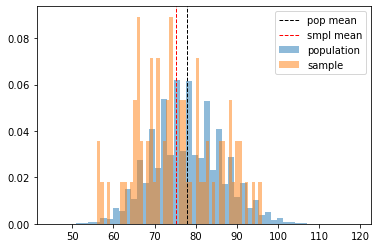

In [4]:
pop_weight_1 = stats.poisson.rvs(loc=22, mu=52, size=150000)
pop_weight_2 = stats.poisson.rvs(loc=22, mu=60, size=150000)
pop_weight = np.concatenate((pop_weight_1,pop_weight_2))

smpl_weight_1 = stats.poisson.rvs(loc=22, mu=47, size=35)
smpl_weight_2 = stats.poisson.rvs(loc=22, mu=60, size=35)
smpl_weight = np.concatenate((smpl_weight_1,smpl_weight_2))

plt.hist(pop_weight, bins=50, alpha=0.5, label='population', density=True)
plt.hist(smpl_weight, bins=50, alpha=0.5, label='sample', density=True)
plt.axvline(pop_weight.mean(), color='black', linestyle='dashed', linewidth=1, label='pop mean')
plt.axvline(smpl_weight.mean(), color='red', linestyle = 'dashed', linewidth=1, label='smpl mean')
plt.legend(loc='upper right')
plt.show()

Как мы видим, у нас получились довольно разные распределения с разными средними значениями. Проверим t-тест в деле!

In [5]:
stats.ttest_1samp(a=smpl_weight, popmean=pop_weight.mean())

Ttest_1sampResult(statistic=-2.335409076036812, pvalue=0.022436151427080588)

P-value получился ниже, чем установленный FPR. Это значит, что мы можем отвергнуть нулевую гипотезу. В то же время, если бы мы установили p-value в размере 1%, то мы не имели бы достаточных оснований для того, чтобы отвергнуть нулевую гипотезу. Это можно наглядно показать, построив доверительные интервалы в 95% и 99%.

In [6]:
sigma = smpl_weight.std()/math.sqrt(70)  #70 is our sample size (35+35)

conf_int_95 = stats.t.interval(alpha=0.95, df=70-1, loc = smpl_weight.mean(), scale=sigma)
conf_int_99 = stats.t.interval(alpha=0.99, df=70-1, loc = smpl_weight.mean(), scale=sigma)
print(pop_weight.mean(), "\n",conf_int_95, "\n", conf_int_99)

77.98335 
 (72.91866379818792, 77.56705048752637) 
 (72.1566904079878, 78.3290238777265)


Как мы видим, среднее значение по популяции действительно попало в 95%-ый, но не в 99%-ый доверительный интервал. Теперь проверим, какой величины эффект мы способны отловить при стандартной мощности в 80% и нашей выборке величиной 70.

In [7]:
tt_solve_power(power=0.8, nobs=70, alpha=0.05)

0.33960608308400736

Как мы видим, наша выборка позволяет нам отловить разницу между средними не меньше, чем 0.33 сигмы.

## Two-sample t-test

Эта разновидность t-теста используется для сравнения двух независимых выборок. Нулевая гипотеза: разницы между средними значениями выборок равна нулю. Альтернативная гипотеза: разница между средними значениями выборок не равна нулю. Сгенирируем данные по весу для жителей Казани и сравним с выборкой по жителям Пскова из прошлого раздела.

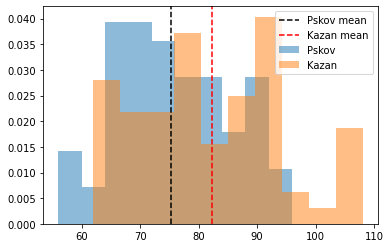

In [8]:
kaz_smpl_weight_1 = stats.poisson.rvs(loc=22, mu=50, size=35)
kaz_smpl_weight_2 = stats.poisson.rvs(loc=22, mu=70, size=35)
kaz_smpl_weight = np.concatenate((kaz_smpl_weight_1,kaz_smpl_weight_2))
plt.hist(smpl_weight, label='Pskov', alpha=0.5, density=True)
plt.hist(kaz_smpl_weight, label='Kazan', alpha=0.5, density=True)
plt.axvline(smpl_weight.mean(), label='Pskov mean', linestyle='dashed', color='black')
plt.axvline(kaz_smpl_weight.mean(), label='Kazan mean', linestyle='dashed', color='red')
plt.legend(loc='upper right')
plt.show()

Кстати, альтернативный способ визуализации двух распределений - это Q-Q plot. Чем более одинаковые распределения, тем ближе точки будут расположены к линии y=x.

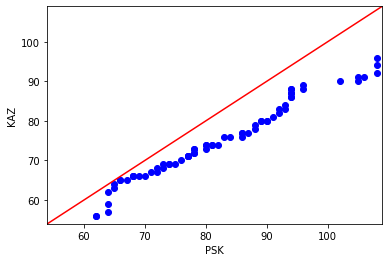

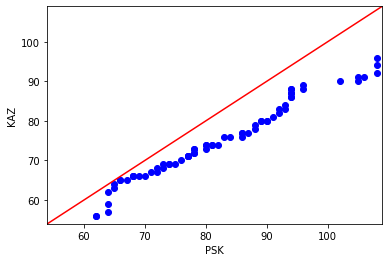

In [9]:
sm.qqplot_2samples(smpl_weight, kaz_smpl_weight, xlabel='PSK', ylabel='KAZ', line='45')

In [10]:
stats.ttest_ind(a=smpl_weight, b=kaz_smpl_weight, equal_var=False)

Ttest_indResult(statistic=-3.654007067187211, pvalue=0.00037338840748398904)

Как и ожидалось, мы получили p-value меньше 0.05, что позволяет нам отвергнуть нулевую гипотезу об отсутствии разницы между средними двух выборок.

## Paired T-test

Эта разновидность t-теста используется для сравнения двух независимых групп. Наиболее частый сценарий - две выборки из одной и той же группы (в нашем случае, жители Пскова), но на разные даты.

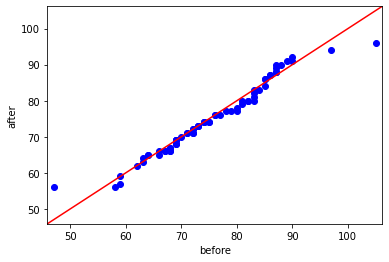

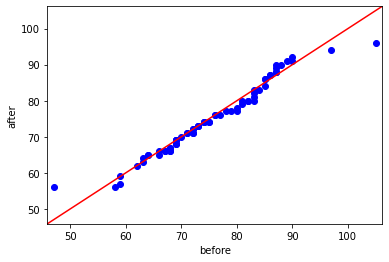

In [11]:
psk_smpl_weight_1 = stats.poisson.rvs(loc=22, mu=47, size=35)
psk_smpl_weight_2 = stats.poisson.rvs(loc=22, mu=60, size=35)
psk_smpl_weight_after = np.concatenate((psk_smpl_weight_1,psk_smpl_weight_2))

sm.qqplot_2samples(smpl_weight, psk_smpl_weight_after, xlabel='before', ylabel='after', line='45')

In [12]:
stats.ttest_rel(smpl_weight, psk_smpl_weight_after)

Ttest_relResult(statistic=-0.2805469673095691, pvalue=0.7798973560427915)

Как и ожидалось, p-value значительно превосходит 5%-ый порог, соответственно, мы не можем отмести нулевую гипотезу и прходим к выводу, что у нас нет оснований утвреждать, что средний вес жителей Пскова изменился за период наблюдения.
При работе с любым t-test важно понимать, что у него есть естественные ограничения. Так, поскольку мы тестируем средние, t-test ОЧЕНЬ чувствителен к выбросам.

# Хи-квадрат тесты (Chi-squared tests)
Один из самых распространенных и широко известных статистических тестов. Используется для исследования двух переменных на предмет зависимости и для проверки того, насколько близко категориальные переменные следуют модельному (ожидаемому) распределению.

## Goodness of fit chi-squared test
Разновидность хи-квадрат теста, используемая для оценки близости к модельному распределению для категориальных переменных. Например, можно протестировать, совпадает ли расовый состав Псковской области с расовым составом РФ в целом (это и есть модельное распределение). По аналогии с t-тестом сгенерируем данные для демонстрации работы теста хи-квадрат.

In [13]:
russia = pd.DataFrame(
    ['white']*100000 + ['asian']*50000 + ['black']*2000 + ['other']*7000
)
pskov = pd.DataFrame(
    ['white']*200 + ['asian']*100 + ['black']*18 + ['other']*22
)
russia_df = pd.crosstab(index=russia[0], columns='count', normalize=True)  #получаем по сути пивот с кол-вом по каждой категории
pskov_df = pd.crosstab(index=pskov[0], columns='count')

def get_html_table(target_df, title): #функция, которая поможет нам отобразить две таблицы рядом, а не одну под одной
    df_style = target_df.style.set_table_attributes(
        "style='border:2px solid;font-size:14px;margin:12px'"
        ).set_caption(title).set_properties(**{'background-color': 'white'})
    return df_style._repr_html_()
russia_html = get_html_table(russia_df, title='Russia')
pskov_html = get_html_table(pskov_df, title='Pskov')
widgets.HBox((widgets.HTML(russia_html), widgets.HTML(pskov_html)))

In [14]:
observed = pskov_df
expected = russia_df*pskov_df['count'].sum()
stats.chisquare(observed, expected)

Power_divergenceResult(statistic=array([48.68151261]), pvalue=array([1.52485013e-10]))

При использовании Хи-квадрат теста важно понимать его ограничения, главным из которых является огромная чувствительность к размеру выборки, что приводит к тому, что на больших выборках (>500) хи-квадрат тест будет выдавать низкие p-value. 

## Chi-squared test of independence

Этот тест используется для проверки того, являются ли две категориальные переменные независимыми. Нулевая гипотеза - да, являются. Альтернативная гипотеза - между переменными есть зависимость. Проверим (на сгенерированных данных), можно ли отвергнуть гипотезу о том, что музыкальные предпочтения не зависят от расы.

In [15]:
#сделаем случайную выборку, предварительно задав вероятности для каждой расы
race = np.random.choice(
    a=['asian', 'white', 'black', 'other'],
    p=[0.24, 0.5, 0.16, 0.1],
    size=1000
)
#проделаем то же самое для жанров
#ОЧевидно, что это полностью независимая от расы процедура, поэтому в результате теста мы ожидаем получить большое p-value
music = np.random.choice(
    a=['rap', 'rock', 'clasical', 'jazz', 'pop'],
    p=[0.4, 0.1, 0.1, 0.05, 0.35],
    size = 1000
)

preferences = pd.DataFrame({"race": race, "genre": music})
preferences_count = pd.crosstab(index=preferences['race'], columns=preferences['genre'])
preferences_count.head()

genre,clasical,jazz,pop,rap,rock
race,,,,,
asian,29,9,84,94,19
black,15,12,60,61,20
other,11,5,40,27,12
white,45,30,184,181,62


In [16]:
stats.chi2_contingency(preferences_count)

(10.6475725616917,
 0.55933849918379,
 12,
 array([[ 23.5  ,  13.16 ,  86.48 ,  85.305,  26.555],
        [ 16.8  ,   9.408,  61.824,  60.984,  18.984],
        [  9.5  ,   5.32 ,  34.96 ,  34.485,  10.735],
        [ 50.2  ,  28.112, 184.736, 182.226,  56.726]]))

Как и ожидалось, p-value значительно выше 5%, что не позволяет нам отвергнуть нулевую гипотезу о независимости.

# Тесты на нормальность распределения

Как понятно из названия, эти тесты проверяют нормально ли распределены наши данные. Сгенирируем два датасета - один распредуленный нормально и один - нет. Используем их для проверки тестов.

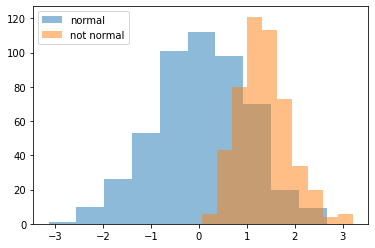

In [17]:
normal = stats.norm.rvs(size=500)
beta = stats.gengamma.rvs(a=1.9, c=1.8,size=500)
plt.hist(normal, label='normal', alpha=0.5)
plt.hist(beta, label='not normal', alpha=0.5)
plt.legend(loc='upper left')

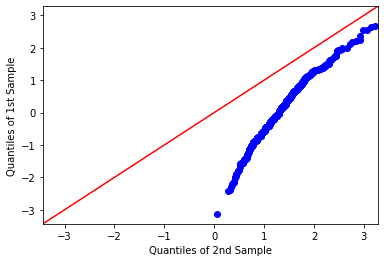

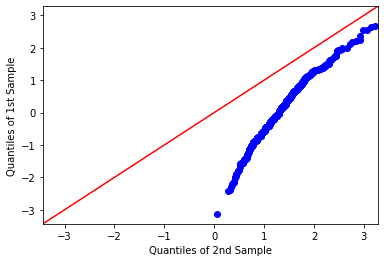

In [18]:
sm.qqplot_2samples(normal, beta, line='45')

## Shapiro-Wilk, D-Agostino tests

Согласно википедии, Шапиро-Уилк демонстрирует самую высокую мощность среди тестов на нормальность, однако Андерсон-Дарлинг, который мы првоерим чуть попозже, практически ему не уступает.

In [19]:
#Shapiro-Wilk test
normal_sw = stats.shapiro(normal)
gengamma_sw = stats.shapiro(beta)
#D-Agostino test
normal_da = stats.normaltest(normal)
gengamma_da = stats.normaltest(beta)
res = pd.DataFrame.from_dict(
    {"Shapiro-Wilk: normal": normal_sw[1],
     "Shapiro-Wilk: gengamma": gengamma_sw[1],
     "D-Agostino: normal": normal_da[1],
     "D-Agostino: gengamma": gengamma_da[1],}, orient='index', columns=['p-value']
)
res.head()

,p-value
Shapiro-Wilk: normal,0.885626
Shapiro-Wilk: gengamma,0.000004
D-Agostino: normal,0.728022
D-Agostino: gengamma,0.000002


## Andersson-Darling test

Тест Андерсона-Дарлинга - это, строго говоря, не совсем тест на нормальность распределения. Этот тест проверяет, можно ли отвергнуть нулевую гипотезу о том, что выборка была сделана из популяции которая следует какому-либо распеределению. Если в роли такого распределения выступает гауссиана, то Андерсон-Дарлинг превращается в тест на нормальность. Нам нужно будет сравнить значение тестовой статистики с критическим значением, соотвутствующим выбранному уровню значимости. Если статистика превосходит его - нулевую гипотезу можно отвергнуть

In [20]:
normal_ad = stats.anderson(normal)
gengamma_ad = stats.anderson(beta)
print(normal_ad,"\n", gengamma_ad)

AndersonResult(statistic=0.17972162986285412, critical_values=array([0.571, 0.651, 0.781, 0.911, 1.083]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ])) 
 AndersonResult(statistic=1.73987091867059, critical_values=array([0.571, 0.651, 0.781, 0.911, 1.083]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


# ANOVA
ANalisys Of VAriance - семейство тестов, которое используется для проверки гипотезы о различии между средними 2-х или более групп (one-way ANOVA), гипотезы о влиянии двух категориальных переменных на результирующую непрерывную пременную (two-way ANOVA) и гипотезы о различии между средними внутри одной и той же группы, но для 2-х или более повторных измерений (например, на разные даты). Стоит отметить, что все эти тесты являются лишь частными случаями линейной регрессии.


## F-test
Прежде чем перейти к, собственно, ANOVA, необходимо рассмотреть F-test, так как именно F-распределение Фишера используется для оценки степени значимости результата в рамках ANOVA. F-тесты - это широкое семейство тестов, однако расчет F практически всегда сводится к отношению двух дисперсий. Так, для линейной регрессии - это будет отношение объясненной дисперсии к необъясненной дисперсии, что для ANOVA, которая является лишь частным случае линейной регрессии, можно сформулировать как отношение межгрупповой дисперсии к внутригрупповой дисперсии.

\begin{align}
F & = \frac{\sigma^2_{explained}}
{\sigma^2_{unexplained}}
&& \equiv &&
F = \frac{\sigma^2_{BtwGrp}}
{\sigma^2_{InGrp}}
\end{align}

F - распределение является двухпараметрическим, т.к. строго говоря представляет собой отношение двух величин, распределенных по хи-квадрат. Поэтому, чтобы задать F-распределение нам нужны степени свободы для числителя и знаменателя, что мы и видим в коде ниже (dfn, dfk). Это особенно важно для ANOVA.

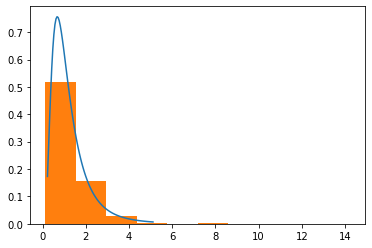

In [21]:
dfn, dfk = 12, 9
#Нарисуем плотность вероятности (pdf)
x = np.linspace(stats.f.ppf(0.01, dfn, dfk), stats.f.ppf(0.99, dfn, dfk),100)
plt.plot(x, stats.f.pdf(x, dfn, dfk))
#сделаем случайную выборку, чтобы посмотреть, как она следует pdf
f = stats.f.rvs(dfn, dfk, size=1000) 
plt.hist(f, density=True)
plt.show()

## One-way ANOVA

Эта вариация ANOVA проверяет, есть ли разница между средними двух и более групп. На практике, поскольку случай с двумя группами покрывается t-тестом, one-way ANOVA используется для 3-х и более групп. Нулевая гипотеза - разницы нет. Альтернативная гипотеза - разница есть.

\begin{align}
H_0: \mu_1=\mu_2= ... =\mu_n \\
H_A: \textrm{at least 2 means aren't equal}
\end{align}

Для получения значимых результатов должны быть соблюдены некоторые требования:

1. Ошибки д.б. нормально распределены
2. Дисперсии групп должны быть одинаковы
3. Значения внутри одной группы д.б. независимы

Как обычно, сгенерируем данные для демонстрации ANOVA в действии. Проверим, отличается ли средний рост в зависимости от расы в нашей выборке.

In [22]:
rg = np.random.default_rng()
smpl = rg.integers(low=50, high=150, size=(300,4))
df = pd.DataFrame(smpl, columns=['white', 'asian', 'black', 'other'])
df.head()

,white,asian,black,other
0,61,135,99,137
1,65,80,143,70
2,69,51,88,117
3,107,110,103,106
4,96,131,118,79


<AxesSubplot:>

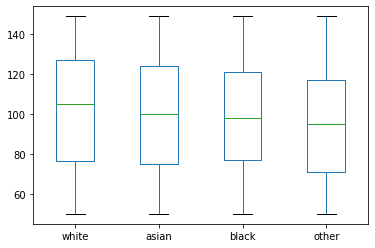

In [23]:
df.boxplot(grid=False)

In [24]:
stats.f_oneway(df['white'], df['asian'], df['black'], df['other'])

F_onewayResult(statistic=2.5246110255783027, pvalue=0.05620951185215194)

## Repeated measures ANOVA (rANOVA)

Эта разновидность ANOVA используется, если мы хотим проверить, есть ли разница не просто между несколькими независимыми группами, а еще и между несколькими наборами измерений, относящимся к соответсвующим группам. Например, в рамках медицинских экспериментов одним и тем же людям могут мерить давление по нескольку раз до/после приема лекарства.
\begin{align}
H_0: \mu_1=\mu_2= ... =\mu_n \\
H_A: \textrm{at least 2 means aren't equal}
\end{align}
Одной из сильных сторон repeated measures ANOVA является тот факт, что она уменьшает размер не объясненной дисперсии. Действительно, для обычной one-way ANOVA F-статистика выглядит следующим образом:
\begin{align}
F=\frac{\sigma^2_{between}}{\sigma^2_{within}},
\end{align}
где $\sigma^2_{between}$ - это дисперсия **между** группами, а $\sigma^2_{within}$ - это дисперсия **внутри** группы или дисперсия ошибки (в том смысле, что мы не можем ее объяснить). Однако для rANOVA ситуация меняется, т.к. мы объясняем часть  $\sigma^2_{within}$ изменчивостью субъекта (т.е. той аналитической единицы, которой соответствуют наши повторные измерения - иными, словами один субъект=одна строка в таблице). Тогда получается следующая картина:
\begin{align}
F=\frac{\sigma^2_{between}}{\sigma^2_{error}}, \quad \sigma^2_{error}=\sigma^2_{within}-\sigma^2_{subject}
\end{align}

Для получения значимых результатов должны быть соблюдены некоторые требования:

1. Данные должны быть получены из случайной выборки
2. Ошибки д.б. нормально распределены
3. Дисперсии разниц между любыми двумя группами измерений (то бишь измерениями, сделанными в разное время) должны быть равны. Это называется Sphericity assumption

Именно из-за пункта 3 rANOVA достаточно редко используется при наличии более чем двух повторных измерений. Часто ее заменяют на linear mixed model.

In [25]:
df = df.melt()
dates = ['31.12.2019','01.01.2020']*600
df['date'] = pd.Series(dates)
df.tail()


,variable,value,date
1195,other,140,01.01.2020
1196,other,52,31.12.2019
1197,other,135,01.01.2020
1198,other,67,31.12.2019
1199,other,102,01.01.2020


In [26]:
# у нас гораздо больше одного наблюдения на комбинацию раса+дата, поэтому говорим анове взять среднюю, задав параметр aggregate_func
aovrm = AnovaRM(data=df, depvar='value', subject='variable', within=['date'], aggregate_func='mean')
res = aovrm.fit()
print(res)

              Anova
     F Value Num DF Den DF Pr > F
---------------------------------
date  0.3981 1.0000 3.0000 0.5729



In [27]:
#теперь сделаем то жэе самое но для случая когда у нас ровно одно наблюдение для каждой расы+даты
df1 = df.groupby(['variable', 'date'], as_index=False).sum() #сумму использую просто для удобства, чтобы сразу получить столбец с цифрами, никакого скрытого смысла здесь нет
df1['value'] = df1['value'] + rg.integers(low=-10000, high=5000, size=8) #добавляю шум
aovrm1 = AnovaRM(data=df1, depvar='value', subject='variable', within=['date'])
res1 = aovrm1.fit()
print(res1)

              Anova
     F Value Num DF Den DF Pr > F
---------------------------------
date  0.1298 1.0000 3.0000 0.7425



## Two-way ANOVA
Это разновидность ановы используется, когда мы хотим проверить влияние двух категориальных переменных на одну непрерывную. Как всегда, есть несколько условий, необходимых для этого теста:

1. Нормальность распределения ошибки
2. Гомоскедастичность (т.е. уже знакомое нам равенство дисперсий между категориями)
3. Независимость категориальных переменных

По большому счету, этот тест представляет собой ничто иное как комбинацию двух one-way ANOVA (по одной на каждую категориальную перемменную) и один тест на независимость для определения влияния взаимодействия категориальных переменных на результирующую переменную. Хороший пример. иллюстрирующий этот концепт, [приводит](https://statisticsbyjim.com/regression/interaction-effects/) Джим Фрост. Если нас спросят, какой соус мы больше любим - кетчуп или шоколадный, скорее всего, мы ответим, что это зависит от того, с какой именно едой мы будем использовать этот соус. Это и есть эффект взаимодействия - в зависимости от типа еды влияние соуса на степень нашего удовольствия от еды будет меняться.

Т.к. это комбинация трех тестов, то и нулевых гипотезы у нас сразу три:
1. Первая переменная не влияет на непрерывную переменную
2. Вторая переменная не влияет на непрерывную переменную
3. Эффект взаимодействия равен нулю

Для разнообразия используем реальный датасет вместо сгенерированных данных. Используем классический датасет о росте зубов в зависимости от типа принимаемого препарата и его дозировки.

In [28]:
df_2w = pd.read_csv("C:\\Users\\Богдан\\Downloads\\ToothGrowth.csv", usecols=['len', 'supp', 'dose'])
df_2w.head(10)

,len,supp,dose
0,4.2,VC,0.5
1,11.5,VC,0.5
2,7.3,VC,0.5
3,5.8,VC,0.5
4,6.4,VC,0.5
5,10.0,VC,0.5
6,11.2,VC,0.5
7,11.2,VC,0.5
8,5.2,VC,0.5
9,7.0,VC,0.5


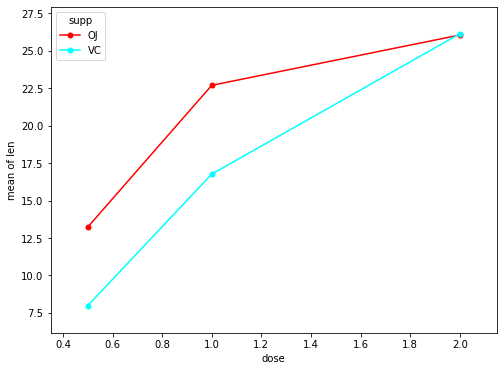

In [29]:
int_plot = sm.graphics.interaction_plot(x=df_2w['dose'], trace=df_2w['supp'], response=df_2w['len'], ms=10)
int_plot.set_size_inches(8,6)
int_plot.show()

In [30]:
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'  #это строка, которая описывает нашу регрессию в стиле R. Она будет использовать, чтобы зафиттить линейную регрессию
model = ols(formula, df_2w).fit()
res = sm.stats.anova_lm(model, typ=2)
print(res)

LinAlgError: SVD did not converge

# Непараметрические тесты

Все тесты, рассмотренные до этого, являются параметрическими. Это значит, что они базируются на определенных предпосылках о распределении (а точнее, о его **параметрах**), из которого выбраны наши данные. Чаще всего в таких тестах требуется нормальное или близкое к нему распределение. В рельных данных, однако, его можно встретить нечасто. Иногда можно привести данные к нормальному или квазинормальному виду путем математических преобразований (например логарифмированием), однако это не панацея, т.к. это может снизить интерпретируемость, да и вообще не всегда работает.
В таких ситуациях на помощь приходят непараметрические тесты. Их принципиальное отличие от параметрических заключается в том, что они не базируются на предположениях о характере распределения, что позволяет с большой свободой использовать их на реальных данных. Кроме того, непараметрические тесты позволяют нам оценивать медианы, а не средние, что может быть очень полезно, например, на датасетах, связанных с доходами населения или затратами внутри приложения и т.п. Из этого, конечно. следует, что непараметрические тесты, как правило, более устойчивы к выбросам.

Ложка дегтя заключается в том, что, как правило, непараметрические тесты имеют меньшую мощность и чаще требует гомоскедастичности. Тем не менее, зачастую у нас может не быть выбора, если у нашего распределения тяжелые хвосты, сильная скошенность или другие серьезные отклонения от условий, допускающих проведение параметрических тестов.


## Тест Манна-Уитни

В англоязычной литературе его еще называют тестом суммы рангов Уилкоксона. Его параметрический собрат - two-sample t-test. Нулевая гипотеза: два распределения равны между собой. Альтернативная гипотеза: эти распеределения не равны. Основные условия исплоьзования:

1. Выборки должны быть независимыми
2. Значения можно упорядочить

Если сделать альтернативную гипотезу более строгой так, чтобы она проверяла не просто разницу между двумя распределениями, а предполагала, что это одинаковые распределения, но одно из них смещено относительно другого, то тест Манна-Уитни превращается в тест на разницу медиан.

Идея теста достаточно проста - мы должны получить все возможные попарные сравнения наших выборок и посчитать кол-во случаев, в которых первая выборка "побеждает". Это и будет U-статистика. Следующее естественным образом возникающее желание - это поделить U на кол-во попарных сравнений, чтобы увидеть долю "побед" первой выборки. Как оказалось, такое желание возникло не только у меня и результат этого нехитрого расчета - это ничто иное, как effect size (если быть более точным, common language effect size, что бы это не значило) или ROC-AUC. В случае теста Манна-Уитни его обычно обозначают буквой f: $\large{f=\frac{U}{n_1n_2}}$, где $n_1$ - размер первой выборки, $n_2$ - второй.

Впрочем, неуемные специалисты по статистике пошли дальше и придумали еще и специальный коэффициент корреляции под названием rank-biserial correlation. Впрочем, рассчитывается этот коэффициент предельно просто. Это разница между долей "побед" первой выборки f и долей "побед" второй выборки u: $\large{r=f-u=f-(1-f)=2f-1=\frac{2U}{n_1n_2}-1}$


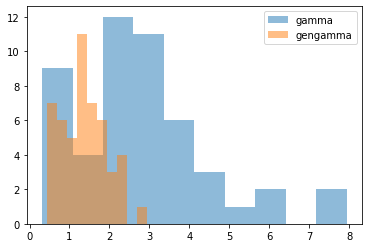

In [34]:
gamma = stats.gamma.rvs(size=50, a=2.5)
gengamma = stats.gengamma.rvs(a=1.9, c=1.8,size=50)
plt.hist(gamma, label='gamma', alpha=0.5)
plt.hist(gengamma, label='gengamma', alpha=0.5)
plt.legend(loc='upper right')

In [38]:
mw_test = stats.mannwhitneyu(gamma, gengamma, alternative='two-sided') #параметр alternative управляет нашей альтернативной гипотезой, а именно тем, ищем ли мы любую разницу (two-sided) или только с одной стороны (less, greater)
f = mw_test[0]/(50*50) #размер обоих наших выборок 50, см выше
r = 2*f-1
print(mw_test,f,r)

MannwhitneyuResult(statistic=1933.0, pvalue=2.5382605686296593e-06) 0.7732 0.5464


## Тест Крускала-Уоллиса

Параметрический аналог - one-way ANOVA. Нулевая гипотеза - обе выборки получены из одного распределения. Альтернативная гипотеза - выборки получены из разных распределений. Используется, когда у нас больше 2-х выборок в кач-ве замены теста Манна-Уитни. В этом случае важно понимать, что положительный результат скажет нам только, что как минимум одна из выборок получена из другого распередления без возможности (в рамках этого теста) определить, какая именно. Основные предположения:

1. Выборки (категории) должны быть независимы
2. Значения измеряемой величины можно упорядочить
3. Наблюдения (то бишь отдельные датапойнты) должны быть независимы.

Как и в случае с тестом Манна-Уитни, если мы сделаем дополнительное более строгое предположение, то этот тест превратится в тест медиан. Суть этого предположения в том, что наши рапределения должны иметь одинаковую форму и отличаться друг от друга лишь смещением.

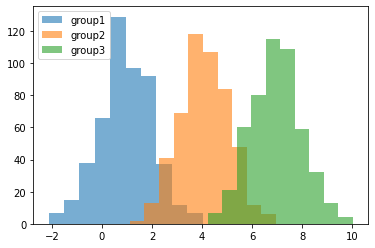

In [41]:
# вот в такой ситуации мы можем расценивать Крускала-Уоллиса как тест медиан
gr1 = stats.norm.rvs(size=500, loc=1)
gr2 = stats.norm.rvs(size=500, loc=4)
gr3 = stats.norm.rvs(size=500, loc=7)
plt.hist(gr1, alpha=0.6, label='group1')
plt.hist(gr2, alpha=0.6, label = 'group2')
plt.hist(gr3, alpha=0.6, label='group3')
plt.legend(loc='upper left')
plt.show()

In [43]:
kwtest = stats.kruskal(gr1, gr2, gr3)
kwtest

KruskalResult(statistic=1290.970742427714, pvalue=4.669443582985076e-281)

## Тест знаков (sign test)

Этот тест имеет несколько вариаций, которые используются для проверки разных нулевых гипотез и, соответственно, имеет разные параметрические аналоги.

### One-sample sign test

Эта версия теста знаков проверяет нулевую гипотезу о равенстве медианы некой величине. Альтернативная, само собой, говорит, что медиана этой величине не равна. Имеет ограниченную полезность, т.к. с нынешними мощностями мы, как правило, можем прсото посчитать медиану генеральной совокупности. Основные допущения:

1. Наблюдения д.б. независимыми
2. Измеряемая величина д.б. непрерывной
3. Значения измеряемой величины можно упорядочить


In [47]:
sign_sample = rg.integers(low=-50, high=120, size=400)
print(np.median(sign_sample))

28.0


In [51]:
testing_sample = rg.choice(sign_sample, size=100)
one_sample_sign_test = sms.descriptivestats.sign_test(testing_sample, 28)
one_sample_sign_test

(-4.5, 0.4215233436157701)

### Paired samples sign test

Параметрический аналог - paired t-test. Нулевая гипотеза - между выборками нет разницы. Альтернативная гипотеза - разница между выборками-таки есть. Чаще всего такого рода тесты используются, когда у нас есть повторные измерения в разное время, но в целом они могут использоваться для любых значений, из которых обоснованно можно составить пару (например, длина правой и левой ноги). Также стоит отметить, что наибольший смысл использование этого теста имеет, когда мы не можем численно оценить разницу между первым и вторым измерением, а можем только сказать что $x_1 > x_2$ или $x_1 < x_2$ или (кто бы мог подумать!) $x_1 = x_2$ (правда, если таких случаев много, лучше использовать trinomial test вместо sign test). Если же мы можем посчитать разницу как $x_1-x_2$, то лучше использовать Wilcoxon signed-rank test, который будет рассмотрен позднее.

Предположим, что мы решили поиграть в микроэкономистов 19 века и получили датасет, базирующийся на ординалистской теории полезности, где наши респонденты сравнивают два блага, но не присваивают своим оценкам числовые полезности, а просто говорят что-то типа "Ios лучше Android".

In [69]:
iphone = rg.choice(['better', 'worse'], p=[0.4, 0.6], size=100)
df_sign_ps = pd.DataFrame(iphone, columns=['result'])
df_sign_ps = pd.crosstab(index=df_sign_ps['result'], columns=['count'])
df_sign_ps.head(10)

col_0,count
result,
better,35
worse,65


In [70]:
#Теперь нам надо посчитать, какова вероятность получения такого результата в рамках обычного биномиального распределения
p_value = stats.binom_test(df_sign_ps['count'])
p_value

0.0035176417229701613

Как и ожидалось, наша выборка говорит нам, что Андроид люди любят больше, чем Айфон Kappa

## Wilcoxon signed-rank test

Параметрический аналог - paired t-test. Нулевая гипотеза - разницы между выборками нет. Альтернативная - она есть. Как и говорилось выше, этот тест можно использовать, только если разница между значениями в каждой паре может быть квантифицирована, т.е. мы можем вычислить их разность. Кроме того, он так же подходит, чтобы проверить гипотезу о том, что медиана разниц между наблюдениями в парах положительна. Основные допущения:

1. Измеряемая величина д.б. непрерывной
2. Все измерения д.б. разбиты на пары
3. Для расчета в Питоне у нас обязательно д.б. не менее 20 пар, иначе мы получим некорректные p-value. Если это условие не выполняется, то p-value придется смотреть в статистических таблицах.
4. Если у нас много нулевых разниц (т.е. ситуаций, где $x_1=x_2$), то следует использовать корректировку Пратта (zero_split='pratt' в scipy.stats.wilcoxon). Само собой, этот пункт не является строгим математическим требованием, а лишь представляет собой практическую рекомендацию. Стоит, однако, отметить, что стандартный тест Вилкоксона просто отбрасывает нулевые разницы, что может быть нежелательно.

Идея теста следующая: мы берем разницы (внутри пар) и ранжируем их по возрастанию, отбрасывая нулевые (в оригинале). После этого применяем некую формулу, запоминать которую я не вижу смысла (всегда можно на вики посмотреть), и получаем тестовую статистику.

Используем датасет из работы самого Вилкоксона, показывающий разницу в высоте между перекрестно и самооплодотворенными злаками

In [33]:
d = [6, 8, 14, 16, 23, 24, 28, 29, 41, -48, 49, 56, 60, -67, 75]
# сначала проверим, можем ли мы отвергнуть нулевую гипотезу об отсутствии разницы в высоте
wil = stats.wilcoxon(d)
wil

WilcoxonResult(statistic=24.0, pvalue=0.04088813291185591)

In [36]:
# теперь проверим, можем ли мы утверждать, что медиана разниц положительна, то бишь первый злак выше второго
wil_med = stats.wilcoxon(d, alternative='greater')
wil_med

WilcoxonResult(statistic=96.0, pvalue=0.020444066455927955)

In [37]:
#протестируем на датасете с большим кол-вом нулей
wil_zeroes = [6, 0, 14, 0, 23, 0, 0, 29, 41, -48, 49, 0, 60, -67, 75, 81, -14, 5, 17, 29]
wil_zeroes_basic = stats.wilcoxon(wil_zeroes)
wil_zeroes_pratt = stats.wilcoxon(wil_zeroes, zero_method='pratt')
print(wil_zeroes_basic, wil_zeroes_pratt)

WilcoxonResult(statistic=26.5, pvalue=0.05698317984206413) WilcoxonResult(statistic=41.5, pvalue=0.03474401669140898)


## Тест Фридмана

Является логичным продолженние Wilcoxon signed-rank test для случаев, когда у нас больше, чем две группы. Параметрический аналог - rANOVA. Соответственно, нулевая гипотеза - разницы между измерениями нет. Альтернативная - разница есть. Кстати, этот тест был разработан никем иным, как отцом монетаризма Милтоном Фридманом. Основыне допущения:

1. Блоки должны быть независимы. Блок - это статистическая единица, для которой мы и составляем наши группы измерений. Например, если 3-м пациентам 5 раз измерили кровяное давление, то каждый пациент - это блок.
2. Измерения могут быть проранжированы

Идея теста следующая: cоставляем т.н. block design matrix размерности $n \times k$, где $n$ - кол-во блоков, $k$ - кол-во измерений (treatments). Это вообще крайне часто используемый инструмент даже в отрыве конкретно от теста Фридмана. Дальше мы ранжируем измерения *внутри каждого блока* и заменяем изначальные значения матрицы их рангами ($\large{r_{ij}}$). После этого в дело вступает хитроумная формула (я ее тут напишу, просто чтобы попрактиковать LaTeX), которая и дает нам тестовую статистику.
\begin{align}
\large{Q = \frac{12n}{k(k+1)}\sum\limits_{j=1}^{k}(\frac{1}{n}\sum\limits_{i=1}^{n}r_{ij}-\frac{k+1}{2})^2}
\end{align}

Стоит также отметить, что для получения нормальной p-value в этом тесте в питоне мы должны соблюсти два условия: $\large{n>10, k>6}$. В противном случае, p-value нам нужно будет искать в статистической таблице.
Сгенерируем (конечно же) датасет, содержащий данные о 20 дегустаторах, оценивавших 8 благородных напитков:



In [42]:
scores_1 = rg.integers(low=0, high=10, size=(20,7))
scores_2 = rg.integers(low=5, high=10, size=20)
scores = np.c_[scores_1, scores_2]
wine_df = pd.DataFrame(scores, columns=['Душа Монаха', 'Виноградный день', 'Ягуар', 'Отвертка', 'Три топора', 'Настойка боярышника', 'Путинка', 'Кумыс'])
wine_df.head()

,Душа Монаха,Виноградный день,Ягуар,Отвертка,Три топора,Настойка боярышника,Путинка,Кумыс
0,0,6,1,7,7,7,3,9
1,6,4,4,6,2,6,3,7
2,5,4,1,6,8,2,7,7
3,5,8,8,9,6,5,3,6
4,2,5,5,1,9,7,5,7


In [47]:
for_test = wine_df.transpose() #транспонируем нашу матрицу для удобства получения списка списков, который сильно упростит нам передачу параметров в функцию теста Фридмана
test = for_test.values
res = stats.friedmanchisquare(*test)
res

FriedmanchisquareResult(statistic=20.333125778331258, pvalue=0.004893343454824405)

## Cochrane test

Это, по большому счету, аналог теста Фридмана для случаев, когда у нас не количественные, а бинарные измерения. Соответственно, нулевая гипотеза - разницы между измерениями нет. Альтернативная - разница есть. Допущения:

1. Блоки независимы и выбраны случайно.
2. Как и для теста Фридмана, для адекватного p-value необходимо большое кол-во блоков ($n \times k\geqslant24$). В целом, лучше побольше, чем 24, конечно.

Предположим, что некто Геральт решил возродить школу Волка, и, не зная точной процедуры Испытания Травами а также желая гуманизирвоать ее, тестирует 3 разных нелетальных варианта. Сгенерируем результаты прохождения Испытания Трав кандидатами в ведьмаки:

In [67]:
opt_1 = rg.integers(0,1,30, endpoint=True)
opt_2 = rg.integers(0,1,30,endpoint=True)
opt_3 = rg.integers(0,1,30, endpoint=True)
df_witcher = pd.DataFrame({'Trial 1': opt_1, 'Trial 2': opt_2, 'Trial 3': opt_3})
df_witcher.head(5)

,Trial 1,Trial 2,Trial 3
0,0,0,1
1,1,1,0
2,1,1,0
3,1,0,1
4,0,1,1


In [68]:
cochrane_witcher = sms.contingency_tables.cochrans_q(df_witcher)
print(cochrane_witcher)

df          2
pvalue      0.3262797946230394
statistic   2.24


## Тест Колмогорова-Смирнова

Этот тест используется для сравнения выборки с модельным распределением. Также может использоваться для проверки альтернативной гипотезы о том, что обе выборки принадлежат к одному распределению. Отдельно стоит отметить, что если нашим моедльным распределением является нормальное, то лучше использовать тест Андерсона-Дарлинга или Шапиро-Уилка. Основная идея заключается в измерения расстояния между графиком распределения выборки и графиком модельного распеределения (или второй выборки):

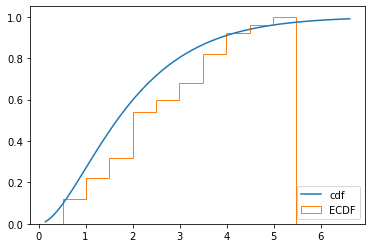

In [56]:
x = np.linspace(stats.gamma.ppf(0.01, 1.99), stats.gamma.ppf(0.99, 1.99), 100) #ppf=percent point function, cdf=cumulative density function
rv = stats.gamma(1.99)
rand = stats.gamma.rvs(2.5, size=50)
plt.plot(x, rv.cdf(x), label='cdf')
plt.hist(rand, histtype='step', cumulative=True, density=True, label='ECDF')
plt.legend(loc='best')
plt.show()
#собсвтенно, расстояние между оранжевой и синей линиями и оценивает статистика Колмогорова

In [60]:
ks1samp_noreject = stats.kstest(rand, stats.gamma(2.5).cdf)
ks1samp_reject = stats.kstest(rand, stats.gamma(1.99).cdf)
print(ks1samp_noreject, ks1samp_reject)

KstestResult(statistic=0.14579797958929142, pvalue=0.21636744676950037) KstestResult(statistic=0.29243840465447485, pvalue=0.00027765965160629163)


Теперь попробуем вариант теста, в котором мы сравниваем не выборку и модельное распрделение, а дву выборки между собой. Кстати, такая вариация теста Колмогорова-Смирнова считается одним из самых полезных непараметрических тестов сравнения двух выборок (если верить Википедии), потому что этот тест чувствителен как к разницам в положении (т.е. смещениям), так и к разнице в формах сравниваемых распределений.

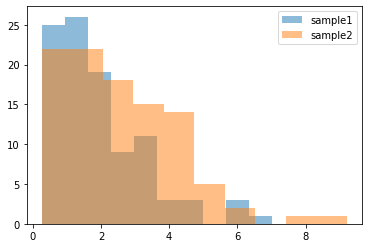

In [62]:
samp1 = stats.gamma.rvs(1.99, size=100)
samp2 = stats.gamma.rvs(2.5, size=100)
plt.hist(samp1, label='sample1', alpha=0.5)
plt.hist(samp2, label='sample2', alpha=0.5)
plt.legend(loc='best')
plt.show()

In [64]:
ks2samp = stats.ks_2samp(samp1, samp2)
ks2samp

Ks_2sampResult(statistic=0.24, pvalue=0.0061340334218580265)